## Simulator

In [1]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1000/1000 [00:00<00:00, 1924.71it/s]


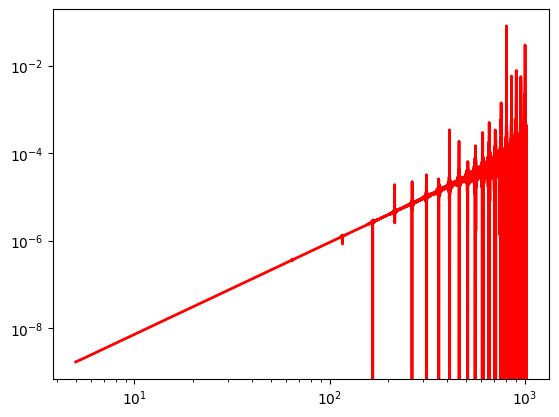

In [2]:
# Simluate data 

fref = 25
CE_PSD = np.genfromtxt("cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(1000) # 100 samples

# Plot simulated data
#for i in range(len(samples)):
#    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

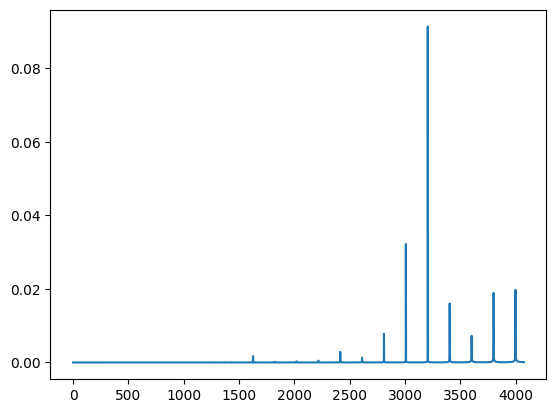

In [3]:
plt.plot(samples[5]['sigma'])

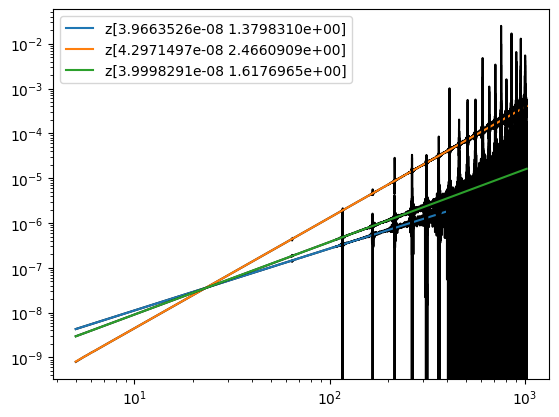

In [4]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

## UNet and Autoencoder

In [5]:

import torch.nn as nn
from torchsummary import summary

# Define Autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(4076, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
  
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,64),
            nn.ReLU(),
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256,4076)
           #nn.ReLU()

        )

        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x



model = Autoencoder()
summary(model, input_size=(1, 4076))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]       1,043,712
              ReLU-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 64]          16,448
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 16]           1,040
              ReLU-6                [-1, 1, 16]               0
           Dropout-7                [-1, 1, 16]               0
            Linear-8                [-1, 1, 64]           1,088
              ReLU-9                [-1, 1, 64]               0
           Linear-10               [-1, 1, 256]          16,640
             ReLU-11               [-1, 1, 256]               0
           Linear-12              [-1, 1, 4076]       1,047,532
Total params: 2,126,460
Trainable params: 2,126,460
Non-trainable params: 0
---------------------------

In [6]:
class UNet_Shallow(nn.Module):
    def __init__(self):
        super(UNet_Shallow, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4)
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),
            nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.Upsample(scale_factor=4.0445) # is this okay?

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



model = UNet_Shallow()
summary(model, input_size=(1, 4076))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 4076]              64
              ReLU-2             [-1, 16, 4076]               0
         MaxPool1d-3             [-1, 16, 1019]               0
            Conv1d-4             [-1, 64, 1019]           3,136
              ReLU-5             [-1, 64, 1019]               0
         MaxPool1d-6              [-1, 64, 254]               0
            Conv1d-7             [-1, 256, 254]          49,408
              ReLU-8             [-1, 256, 254]               0
         MaxPool1d-9              [-1, 256, 63]               0
           Conv1d-10               [-1, 64, 63]          49,216
             ReLU-11               [-1, 64, 63]               0
         Upsample-12              [-1, 64, 252]               0
           Conv1d-13              [-1, 16, 252]           3,088
             ReLU-14              [-1, 

In [7]:
# Pre-Process Data

from torch.utils.data import TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

x_samples = samples['x'] 
m_samples = samples['m']


# Scaling data across each sample (need to transpose first)
transposed_x = x_samples.T
transposed_m = m_samples.T

scaler = StandardScaler()
#scaler = MinMaxScaler()

x_T_scaled = scaler.fit_transform(transposed_x)
m_T_scaled = scaler.fit_transform(transposed_m)

x_scaled = x_T_scaled.T
m_scaled = m_T_scaled.T

x_train, x_test, m_train, m_test = train_test_split(x_scaled, m_scaled, test_size=0.1)

from torch.utils.data import TensorDataset

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_17001/2274541696.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
x_train_tensor.shape

torch.Size([900, 4076])

In [9]:
# Check that normalization worked
print("Min: ",np.min(x_scaled[0,:]))
print("Max: ",np.max(x_scaled[0,:]))
print("Mean: ",np.average(x_scaled[0,:]))
print("Var: ", np.var(x_scaled[0,:]))

Min:  -4.76472
Max:  41.823605
Mean:  -1.4974278e-08
Var:  0.9999999


In [10]:
x_train.shape

(900, 4076)

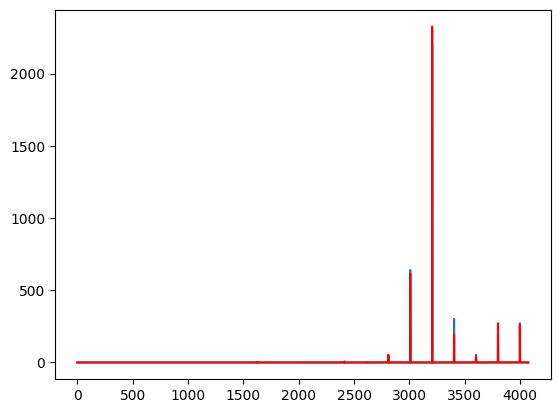

In [11]:
# Getting variance in each dimension of data
def Var_By_Column(data):
    
    sigma = np.zeros(len(data[0,:]))

    for i in range(len(sigma)):
        sigma[i] = np.var(data[:,i])

    return sigma

sig_test = Var_By_Column(x_test)
sig_train = Var_By_Column(x_train)

plt.plot(sig_test)
plt.plot(sig_train, c="r")

In [12]:
# Define weighted loss function
def MSELoss_Weighted(sigma, predictions, targets):
    """""
    Computes the mean squared error (MSE) loss between predictions and targets, 
    weighted by the variance of the dimension
    
    Args:
        predictions (torch.Tensor): The predicted values.
        targets (torch.Tensor): The target values.
        
    Returns:
        torch.Tensor: The computed MSE loss.
    """
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    sigma = torch.Tensor(sigma)
    
    squared_error = 1/sigma**2 * (predictions - targets)**2 
    
    mse_loss = torch.mean(squared_error)
    
    return mse_loss

Epoch [1/100], Loss: 43742.6219618056
Epoch [2/100], Loss: 34268.2572829861
Epoch [3/100], Loss: 17834.3757899306
Epoch [4/100], Loss: 9401.5804383681
Epoch [5/100], Loss: 7227.3389040799
Epoch [6/100], Loss: 5752.5941644965
Epoch [7/100], Loss: 4997.9016427951
Epoch [8/100], Loss: 4557.1131467014
Epoch [9/100], Loss: 4154.3023784722
Epoch [10/100], Loss: 3397.4538422309
Epoch [11/100], Loss: 3143.3965017361
Epoch [12/100], Loss: 2873.6490679253
Epoch [13/100], Loss: 2518.8955371094
Epoch [14/100], Loss: 2337.0211366102
Epoch [15/100], Loss: 2199.9987109375
Epoch [16/100], Loss: 1977.8711702474
Epoch [17/100], Loss: 1873.9544476997
Epoch [18/100], Loss: 1639.9392241753
Epoch [19/100], Loss: 1697.0209244792
Epoch [20/100], Loss: 1450.9281987847
Epoch [21/100], Loss: 1386.1823654514
Epoch [22/100], Loss: 1367.8858094618
Epoch [23/100], Loss: 1292.4325358073
Epoch [24/100], Loss: 1175.4540025499
Epoch [25/100], Loss: 1110.8685812717
Epoch [26/100], Loss: 1043.4584735786
Epoch [27/100], Lo

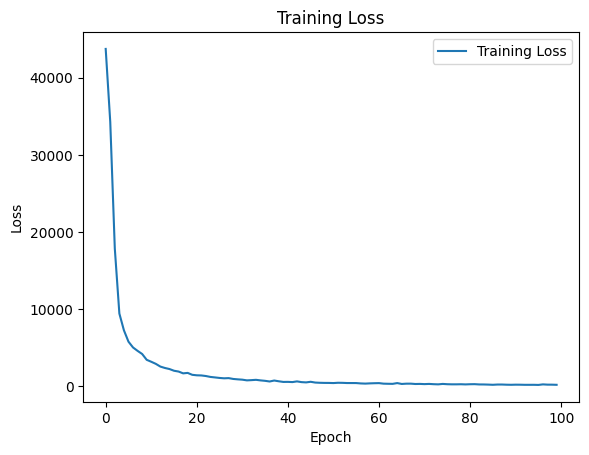

In [14]:
# Autoencoder
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=.0001) # try smaller lr

train_losses = []
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1)) 
        #loss = criterion(outputs, targets.unsqueeze(1))  
        loss = MSELoss_Weighted(sig_train, outputs, targets.unsqueeze(1))  
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")


plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [15]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.unsqueeze(1)) 
        #test_loss += criterion(outputs, targets.unsqueeze(1)).item() * inputs.size(0)
        test_loss += MSELoss_Weighted(sig_test,outputs, targets.unsqueeze(1)).item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 3691.5257


Epoch [1/100], Loss: 23581.3995399306
Epoch [2/100], Loss: 19468.1392274306
Epoch [3/100], Loss: 18977.8983506944
Epoch [4/100], Loss: 18374.0312934028
Epoch [5/100], Loss: 18157.5101822917
Epoch [6/100], Loss: 17420.5242838542
Epoch [7/100], Loss: 17180.9971875000
Epoch [8/100], Loss: 16916.5704774306
Epoch [9/100], Loss: 16316.5983723958
Epoch [10/100], Loss: 16027.8506336806
Epoch [11/100], Loss: 15875.3353602431
Epoch [12/100], Loss: 15289.7604991319
Epoch [13/100], Loss: 15350.9562934028
Epoch [14/100], Loss: 14770.8280859375
Epoch [15/100], Loss: 14607.1796831597
Epoch [16/100], Loss: 14689.7071657986
Epoch [17/100], Loss: 14067.7386545139
Epoch [18/100], Loss: 13966.6343185764
Epoch [19/100], Loss: 13512.1573871528
Epoch [20/100], Loss: 13217.8712326389
Epoch [21/100], Loss: 12837.6568880208
Epoch [22/100], Loss: 12564.0295442708
Epoch [23/100], Loss: 12611.4121484375
Epoch [24/100], Loss: 12019.9154166667
Epoch [25/100], Loss: 12255.0040277778
Epoch [26/100], Loss: 12508.152760

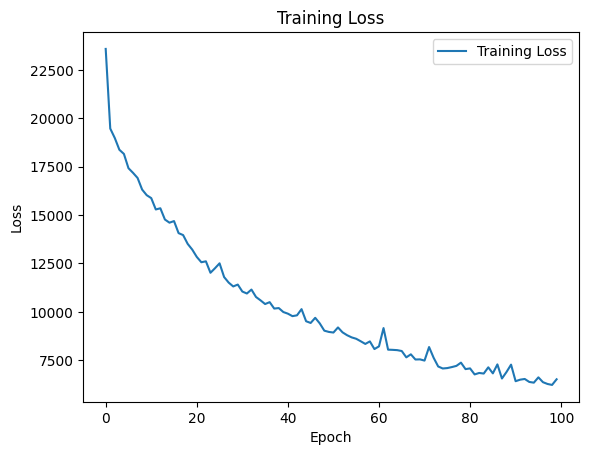

In [16]:
# UNet
model = UNet_Shallow()
optimizer = optim.Adam(model.parameters(), lr=.0001) # try smaller lr

train_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1)) 
        #loss = criterion(outputs, targets.unsqueeze(1))  
        loss = MSELoss_Weighted(sig_train, outputs, targets.unsqueeze(1))  
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")


plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

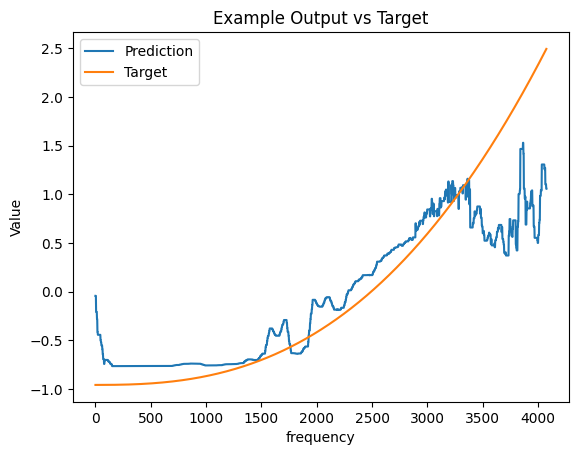

In [17]:
# plotting example output

sample_index = 16

sample, target = test_dataset[sample_index] 

# Pass the sample through the model to get the prediction
with torch.no_grad():
    model.eval()
    prediction = model(sample.unsqueeze(0).unsqueeze(0)) 
    
# Plot the example output versus its target
plt.plot(prediction.squeeze().numpy(), label='Prediction')
plt.plot(target.numpy(), label='Target')
plt.xlabel('frequency')
plt.ylabel('Value')
plt.title('Example Output vs Target')
plt.legend()
plt.show()

In [17]:
# Evaluation on test set

model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.unsqueeze(1)) 
        #test_loss += criterion(outputs, targets.unsqueeze(1)).item() * inputs.size(0)
        test_loss += MSELoss_Weighted(sig_test,outputs, targets.unsqueeze(1)).item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 136093.9700


In [181]:
# How to extract encoder part example

import torch.nn as nn

class Encoder(nn.Module): # Change to fit our UNet structure
    def __init__(self, in_channels):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

in_channels = 1  
encoder_model = Encoder(in_channels)

# Load the weights of the UNet model and copy them to the encoder model
encoder_model.load_state_dict(model.encoder.state_dict())

# Set the encoder model to evaluation mode
encoder_model.eval()


RuntimeError: Error(s) in loading state_dict for Encoder:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.3.weight", "encoder.3.bias", "encoder.6.weight", "encoder.6.bias". 
	Unexpected key(s) in state_dict: "0.weight", "0.bias", "3.weight", "3.bias", "6.weight", "6.bias". 